## Difference-in-Differences


In [29]:
%matplotlib inline

# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


import seaborn as sns
sns.set()
sns.set_context('notebook', font_scale=1.75)

import  warnings
warnings.filterwarnings('ignore')



## Part I: The Data


In [16]:
def generate_dd_data(num_classes=50, low_lm=50, high_lm=80, var_lm=5, random_seed=10900):
    
    np.random.seed(random_seed)
    
    # set up our Data Frame with the necessary columns
    result = pd.DataFrame(columns=['class_number',
                                   'month',
                                   'post_launch_day',
                                   'received_wni',
                                   'avg_learner_mastery'])
    
    # we want to generate 10 months worth of data for every class
    months = pd.date_range('2019-01-01', '2019-10-01', freq='MS')
    num_months = len(months)

    # we want to include month-specific effects
    month_effect = [10, 5, -10, -5, 0, 0, -5, -10, 10, 5]
    
    # the first five months correspond to observations before Launch Day,
    # and the next five months correspond to observations after Launch Day
    wni_launched = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
    
    # for every class...
    for i in range(num_classes):
        
        # Average Learner Mastery for every class will be normally distribution around some
        # mean; this mean will be drawn from the following uniform distribution...
        avg_learner_mastery_of_this_class = np.random.randint(low_lm, high_lm)
        
        # ...and then observations will be taken
        avg_lm_scores = np.random.normal(avg_learner_mastery_of_this_class, var_lm, num_months)
        
        # We'll randomly assign each class to the treatment and control groups
        if np.random.rand() < .5:
            received_wni = 1
            
            # If it's in the treatment group, then the class will improve by an average of 8
            # Learner Mastery points after Launch Day
            lm_boost = np.random.normal(8, 2, num_months)*wni_launched
            
            # We're also going to give all treatment classes a 5-point Learner Mastery
            # boost because we assume they're naturally better somehow (perhaps because they're
            # taught by more motivated instructors)
            lm_boost += np.random.normal(5, 1, num_months)
        else:
            received_wni = 0
            
            # If it's in the control group, then the class will improve by an average of 3
            # Learner Mastery points after Launch Day (this could be for any number of reasons, but
            # let's just assume we somehow got more motivated learners on the platform)
            lm_boost = np.random.normal(3, 1, num_months)*wni_launched
        
        # Increase average learner mastery scores from above by the "boost" we just calculated
        avg_lm_scores += lm_boost
        
        # Add month-specific learner mastery effects (e.g., January will be 10 points higher across all
        # all classes, since learners are more motivated at the beginning of the year)
        avg_lm_scores += np.random.multivariate_normal(month_effect, np.identity(10))
        
        # Add an ARMA process to make this examle more real-world
        avg_lm_scores += sm.tsa.arma_generate_sample([1, -.2, -.1], [1], nsample=10)
            
        tmp_frame = pd.DataFrame({
            'class_number': 'Class ' + str(i),
            'month': months,
            'post_launch_day': wni_launched,
            'received_wni': received_wni,
            'avg_learner_mastery': avg_lm_scores
        })
        
        result = result.append(tmp_frame)
        
    return result

In [17]:
df = generate_dd_data()

In [18]:
print (df.shape)
df.head()

(500, 5)


,class_number,month,post_launch_day,received_wni,avg_learner_mastery
0,Class 0,2019-01-01,0,1,77.487571
1,Class 0,2019-02-01,0,1,67.069682
2,Class 0,2019-03-01,0,1,51.744760
3,Class 0,2019-04-01,0,1,60.313582
4,Class 0,2019-05-01,0,1,69.690571


In [19]:
df.groupby('received_wni').agg({'class_number': 'nunique'})

,class_number
received_wni,
0,25
1,25



## Part II: Vetting Assumptions


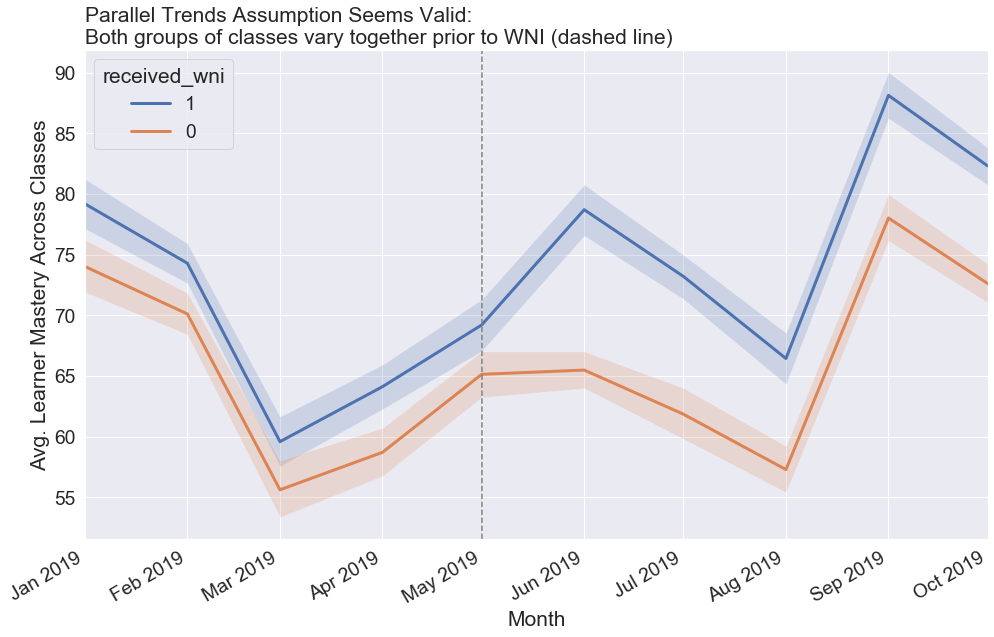

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16.18, 10))

sns.tsplot(time='month', value='avg_learner_mastery', unit='class_number', condition='received_wni',
           data=df, ax=ax, lw=3)

ax.set_title('Parallel Trends Assumption Seems Valid:\nBoth groups of classes vary together prior to WNI (dashed line)', loc='left')
ax.set_xlabel('Month')
ax.set_ylabel('Avg. Learner Mastery Across Classes')

fig.autofmt_xdate()

# x-axis comes as integer by default... 
int_months = df.month.unique().astype(np.int64)

ax.set_xticks(int_months)
ax.set_xticklabels(pd.Series(df.month.unique()).apply(lambda x: pd.datetime.strftime(x, '%b %Y')))

ax.axvline(int_months[4], ls='dashed', color='grey')



## Part III: The World's Simplest, Dumbest Model


In [21]:
dfg = df.groupby(['received_wni', 'post_launch_day']).mean().reset_index()
dfg

,received_wni,post_launch_day,avg_learner_mastery
0,0,0,64.733482
1,0,1,67.064582
2,1,0,69.291525
3,1,1,77.768548


In [22]:
reg = smf.ols('avg_learner_mastery ~ post_launch_day + received_wni + post_launch_day:received_wni', dfg).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     avg_learner_mastery   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                    nan
Method:                  Least Squares   F-statistic:                     0.000
Date:                 Mon, 10 Feb 2020   Prob (F-statistic):                nan
Time:                         12:47:17   Log-Likelihood:                 118.55
No. Observations:                    4   AIC:                            -229.1
Df Residuals:                        0   BIC:                            -231.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       64.7335        inf          0        nan         nan         nan
post_launch_day                  2.3311        inf          0        nan         nan         nan
received_wni                     4.5580        inf          0        nan         nan         nan
post_launch_day:received_wni     6.1459        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.048
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.963
Skew:                          -1.155   Prob(JB):                        0.618
Kurtosis:                       2.333   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
((dfg.loc[3, 'avg_learner_mastery'] - dfg.loc[2, 'avg_learner_mastery']) -
 (dfg.loc[1, 'avg_learner_mastery'] - dfg.loc[0, 'avg_learner_mastery']))

6.145922799807323



## Part IV: Difference-in-Differences (Simple Pre/Post)


In [24]:
dfgg = df.groupby(['class_number', 'received_wni', 'post_launch_day']).mean().reset_index()

In [25]:
reg = smf.ols('avg_learner_mastery ~ post_launch_day + class_number + post_launch_day:received_wni',
              dfgg).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     avg_learner_mastery   R-squared:                       0.959
Model:                             OLS   Adj. R-squared:                  0.916
Method:                  Least Squares   F-statistic:                     22.19
Date:                 Mon, 10 Feb 2020   Prob (F-statistic):           7.25e-21
Time:                         12:47:21   Log-Likelihood:                -209.90
No. Observations:                  100   AIC:                             523.8
Df Residuals:                       48   BIC:                             659.3
Df Model:                           51                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       66.8270      2.055     32.526      0.000      62.696      70.958
class_number[T.Class 1]          2.2747      2.849      0.798      0.429      -3.454       8.003
class_number[T.Class 10]         4.9578      2.906      1.706      0.094      -0.884      10.800
class_number[T.Class 11]         8.3125      2.906      2.861      0.006       2.470      14.155
class_number[T.Class 12]         3.5702      2.906      1.229      0.225      -2.272       9.412
class_number[T.Class 13]         5.5187      2.906      1.899      0.064      -0.323      11.361
class_number[T.Class 14]       -12.3482      2.849     -4.334      0.000     -18.077      -6.620
class_number[T.Class 15]        -3.1624      2.849     -1.110      0.273      -8.891       2.566
class_number[T.Class 16]        -7.2447      2.906     -2.493      0.016     -13.087      -1.403
class_number[T.Class 17]         9.1686      2.906      3.156      0.003       3.327      15.011
class_number[T.Class 18]         3.3090      2.849      1.161      0.251      -2.420       9.038
class_number[T.Class 19]         0.1640      2.849      0.058      0.954      -5.565       5.893
class_number[T.Class 2]         -0.2282      2.906     -0.079      0.938      -6.070       5.614
class_number[T.Class 20]       -11.4501      2.906     -3.941      0.000     -17.292      -5.608
class_number[T.Class 21]        -7.9446      2.906     -2.734      0.009     -13.787      -2.103
class_number[T.Class 22]        -0.7873      2.906     -0.271      0.788      -6.629       5.055
class_number[T.Class 23]         4.7878      2.906      1.648      0.106      -1.054      10.630
class_number[T.Class 24]         4.3259      2.849      1.518      0.136      -1.403      10.055
class_number[T.Class 25]        15.2458      2.849      5.351      0.000       9.517      20.974
class_number[T.Class 26]        10.9823      2.849      3.855      0.000       5.254      16.711
class_number[T.Class 27]         3.1080      2.906      1.070      0.290      -2.734       8.950
class_number[T.Class 28]       -14.6982      2.906     -5.059      0.000     -20.540      -8.856
class_number[T.Class 29]       -11.1964      2.906     -3.853      0.000     -17.039      -5.354
class_number[T.Class 3]         -5.8101      2.906     -2.000      0.051     -11.652       0.032
class_number[T.Class 30]         6.1017      2.849      2.142      0.037       0.373      11.830
class_number[T.Class 31]       -12.3135      2.906     -4.238      0.000     -18.156      -6.471
class_number[T.Class 32]        -4.7256      2.906     -1.626      0.110     -10.568       1.116
class_number[T.Class 33]       -10.9792      2.906     -3.779      0.000     -16.821      -5.137
class_number[T.Class 34]         4.1914      2.906      1.443    



## Appendix: Bootstrap an Estimate

In [26]:
classes = dfgg.class_number.unique()
num_classes = len(classes)

num_reps = 1000
result = np.zeros([num_reps, 1])

for i in range(num_reps):

    tmp_classes = pd.DataFrame({'class_number': np.random.choice(classes, num_classes)})

    tmp_df = tmp_classes.merge(dfgg, how='inner', on=['class_number'])

    tmp_dfg = tmp_df.groupby(['received_wni', 'post_launch_day']).mean().reset_index()

    post = (tmp_dfg['received_wni'] == 1) & (tmp_dfg['post_launch_day'] == 1)
    pre = (tmp_dfg['received_wni'] == 1) & (tmp_dfg['post_launch_day'] == 0)

    naive_treatment_difference = (tmp_dfg[post]['avg_learner_mastery'].iloc[0] -
                                  tmp_dfg[pre]['avg_learner_mastery'].iloc[0])

    post = (tmp_dfg['received_wni'] == 0) & (tmp_dfg['post_launch_day'] == 1)
    pre = (tmp_dfg['received_wni'] == 0) & (tmp_dfg['post_launch_day'] == 0)

    control_difference = (tmp_dfg[post]['avg_learner_mastery'].iloc[0] -
                          tmp_dfg[pre]['avg_learner_mastery'].iloc[0])

    result[i] = naive_treatment_difference - control_difference

In [27]:
print ("Bootstrap estimate of treatment effect: Median estimate of %.2f, 95%% CI from %.2f to %.2f" % (
    np.percentile(result, 50),
    np.percentile(result, 2.5),
    np.percentile(result, 97.5)))

Bootstrap estimate of treatment effect: Median estimate of 6.15, 95% CI from 3.94 to 8.26




## Appendix: Flip Part VI into Part IV


In [28]:
df_resid = df.copy()

reg = smf.ols('avg_learner_mastery ~ month + class_number', df_resid).fit()
df_resid['resid_learner_mastery'] = df_resid.avg_learner_mastery - reg.predict(df_resid)

reg_resid = smf.ols('resid_learner_mastery ~ post_launch_day', df_resid[df_resid.received_wni == 1]).fit()
reg_resid.summary()                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     resid_learner_mastery   R-squared:                       0.079
Model:                               OLS   Adj. R-squared:                  0.075
Method:                    Least Squares   F-statistic:                     21.25
Date:                   Mon, 10 Feb 2020   Prob (F-statistic):           6.46e-06
Time:                           12:47:34   Log-Likelihood:                -769.24
No. Observations:                    250   AIC:                             1542.
Df Residuals:                        248   BIC:                             1550.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.5365      0.471     -3.260      0.001      -2.465      -0.608
post_launch_day[T.1]     3.0730      0.667      4.610      0.000       1.760       4.386
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.120
Skew:                          -0.049   Prob(JB):                        0.942
Kurtosis:                       3.044   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""